<a href="https://colab.research.google.com/github/LEDazzio01/Simplest-Conformal-Prediction/blob/main/20250405-cpb-p-values-and-nc-scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P-Values and Nonconformity Scores in Conformal Prediction

This notebook explores the **mathematical foundation** of conformal prediction: how nonconformity scores and p-values work together to create prediction sets with guaranteed coverage.

## What You'll Learn

1. How **nonconformity scores** measure "strangeness" of predictions
2. How **p-values** quantify uncertainty for new data points
3. How to construct **prediction sets** for classification problems

## Key Concepts

| Concept | Definition |
|---------|------------|
| **Nonconformity Score** | Measures how "unusual" a prediction is according to the model |
| **p-value** | Proportion of calibration points with scores ≥ the test point's score |
| **Prediction Set** | Set of labels with p-values above threshold α |

## Why This Matters

Unlike regression (which produces intervals), classification needs **prediction sets**—collections of possible labels. P-values let us decide which labels to include while maintaining coverage guarantees.

In [11]:
# --- 1. Import Libraries ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from typing import List, Tuple

In [12]:
# --- 2. Load and Split Data ---

def load_and_split_data(test_size: float = 0.3, random_state: int = 42):
    """Load Iris dataset and split into train/calibration/test sets."""
    iris = load_iris()
    X, y = iris.data, iris.target

    # First split: train vs (calibration + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Second split: calibration vs test
    X_train, X_cal, y_train, y_cal = train_test_split(
        X_train, y_train, test_size=0.5, random_state=random_state
    )

    # Scale features (important for logistic regression)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_cal = scaler.transform(X_cal)
    X_test = scaler.transform(X_temp)

    return X_train, X_cal, X_test, y_train, y_cal, y_temp, scaler

# Load and split the data
X_train, X_cal, X_test, y_train, y_cal, y_test, scaler = load_and_split_data()

print(f"Training set:    {len(X_train)} samples")
print(f"Calibration set: {len(X_cal)} samples")
print(f"Test set:        {len(X_test)} samples")
print(f"Classes:         {np.unique(y_train)} (setosa, versicolor, virginica)")

Training set:    52 samples
Calibration set: 53 samples
Test set:        45 samples
Classes:         [0 1 2] (setosa, versicolor, virginica)


## Step 1: Understanding Nonconformity Scores

The **nonconformity score** measures how "strange" a prediction is. For classification:

$$\text{score} = 1 - P(\text{true class})$$

### Intuition

| Model Confidence | Score | Interpretation |
|-----------------|-------|----------------|
| High (P ≈ 1.0) | Low (~0) | Prediction conforms well |
| Low (P ≈ 0.3) | High (~0.7) | Prediction is unusual |

A point with a **high nonconformity score** is one where the model is uncertain or wrong.

In [13]:
# --- 3. Define Nonconformity Score ---

def nonconformity_score(model, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calculate nonconformity scores for classification.
    
    Score = 1 - P(true class)
    Higher score = model is less confident in the correct label
    """
    probabilities = model.predict_proba(X)
    true_class_probs = probabilities[np.arange(len(y)), y]
    return 1 - true_class_probs

## Step 2: Train a Classification Model

We use **Logistic Regression** on the Iris dataset. Conformal prediction works with any model that outputs class probabilities.

In [14]:
# --- 4. Train the Model ---

model = LogisticRegression(random_state=42, max_iter=200)
model.fit(X_train, y_train)

# Check accuracy
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
print(f"Training accuracy: {train_acc:.1%}")
print(f"Test accuracy:     {test_acc:.1%}")

Training accuracy: 100.0%
Test accuracy:     95.6%


## Step 3: Compute Calibration Scores

We calculate nonconformity scores on the **calibration set**. These scores tell us how the model typically "fails"—essential for setting thresholds.

In [15]:
# --- 5. Calculate Calibration Scores ---

cal_scores = nonconformity_score(model, X_cal, y_cal)

print(f"Calibration scores:")
print(f"  Min:  {cal_scores.min():.3f}")
print(f"  Max:  {cal_scores.max():.3f}")
print(f"  Mean: {cal_scores.mean():.3f}")

Calibration scores:
  Min:  0.005
  Max:  0.764
  Mean: 0.197


## Step 4: The Empirical P-Value

The **p-value** answers: *"How unusual is this test point compared to calibration data?"*

$$p\text{-value} = \frac{|\{i : s_i \geq s_{\text{test}}\}| + 1}{n_{\text{cal}} + 1}$$

Where:
- $s_i$ = calibration scores
- $s_{\text{test}}$ = test point's score
- The "+1" terms ensure the p-value is always defined

### Interpretation

| p-value | Meaning |
|---------|---------|
| High (≈1.0) | Test point is typical (many calibration points are "stranger") |
| Low (≈0.0) | Test point is unusual (few calibration points are "stranger") |

In [16]:
# --- 6. Implement P-Value Calculation ---

def calculate_p_value(test_score: float, calibration_scores: np.ndarray) -> float:
    """
    Calculate empirical p-value for a test point.
    
    p-value = proportion of calibration scores >= test score
    Higher p-value = test point is more "normal"
    """
    n_greater_equal = np.sum(calibration_scores >= test_score)
    return (n_greater_equal + 1) / (len(calibration_scores) + 1)

## Step 5: Constructing Prediction Sets

For each test point, we build a **prediction set** containing all plausible labels:

### Algorithm

For each possible label $y$:
1. Calculate nonconformity score assuming $y$ is correct
2. Compute the p-value
3. Include $y$ in the set if p-value ≥ α

### Coverage Guarantee

With confidence level $(1 - \alpha)$, the true label will be in the prediction set at least $(1 - \alpha) \times 100\%$ of the time.

In [17]:
# --- 7. Build Prediction Sets ---

def create_prediction_sets(model, X_test: np.ndarray, labels: np.ndarray, 
                           cal_scores: np.ndarray, alpha: float = 0.1) -> List[List[int]]:
    """
    Create prediction sets for each test point.
    
    A label is included if its p-value >= alpha.
    """
    prediction_sets = []
    
    for x in X_test:
        current_set = []
        x_reshaped = x.reshape(1, -1)
        
        for label in labels:
            # Score assuming this label is correct
            score = nonconformity_score(model, x_reshaped, np.array([label]))[0]
            # Calculate p-value
            p_val = calculate_p_value(score, cal_scores)
            # Include label if p-value meets threshold
            if p_val >= alpha:
                current_set.append(label)
        
        prediction_sets.append(current_set)
    
    return prediction_sets

# Create prediction sets with 90% target coverage
alpha = 0.1
labels = np.unique(y_train)
prediction_sets = create_prediction_sets(model, X_test, labels, cal_scores, alpha)

# Show set size distribution
set_sizes = [len(s) for s in prediction_sets]
print(f"Prediction set sizes:")
print(f"  Size 1: {set_sizes.count(1)} samples (single prediction)")
print(f"  Size 2: {set_sizes.count(2)} samples (ambiguous)")
print(f"  Size 3: {set_sizes.count(3)} samples (very uncertain)")

Prediction set sizes:
  Size 1: 45 samples (single prediction)
  Size 2: 0 samples (ambiguous)
  Size 3: 0 samples (very uncertain)


## Step 6: Evaluate Coverage

The **coverage** is the proportion of test points where the true label is in the prediction set.

With proper calibration, coverage should be ≥ $(1 - \alpha)$.

In [18]:
# --- 8. Evaluate Coverage ---

def calculate_coverage(prediction_sets: List[List[int]], y_true: np.ndarray) -> float:
    """Calculate empirical coverage."""
    covered = sum(y in pred_set for y, pred_set in zip(y_true, prediction_sets))
    return covered / len(y_true)

coverage = calculate_coverage(prediction_sets, y_test)

print(f"Target coverage:  {1 - alpha:.0%}")
print(f"Actual coverage:  {coverage:.1%}")
print(f"Difference:       {(coverage - (1 - alpha)) * 100:+.1f}%")

Target coverage:  90%
Actual coverage:  95.6%
Difference:       +5.6%


## Step 7: Visualize P-Value Distribution

For correctly labeled points, p-values should be **approximately uniform** between 0 and 1. This is a diagnostic check for the validity of conformal prediction.

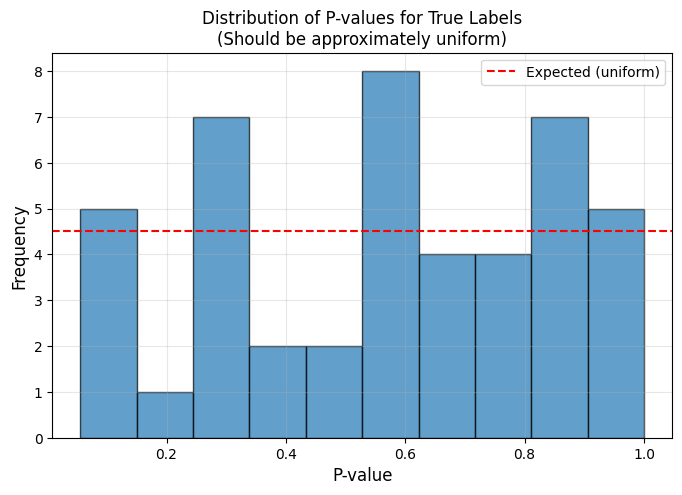

In [19]:
# --- 9. Visualize P-Value Distribution ---

def get_true_label_pvalues(model, X_test, y_test, cal_scores):
    """Calculate p-values for the true labels."""
    p_values = []
    for x, y_true in zip(X_test, y_test):
        x_reshaped = x.reshape(1, -1)
        score = nonconformity_score(model, x_reshaped, np.array([y_true]))[0]
        p_val = calculate_p_value(score, cal_scores)
        p_values.append(p_val)
    return np.array(p_values)

p_values = get_true_label_pvalues(model, X_test, y_test, cal_scores)

plt.figure(figsize=(8, 5))
plt.hist(p_values, bins=10, edgecolor='black', alpha=0.7)
plt.axhline(y=len(p_values)/10, color='red', linestyle='--', 
            label='Expected (uniform)')
plt.xlabel("P-value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of P-values for True Labels\n(Should be approximately uniform)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Step 8: Example Predictions

Let's examine some specific predictions to understand what the prediction sets look like.

In [20]:
# --- 10. Show Example Predictions ---

iris = load_iris()
target_names = iris.target_names

print("Example Prediction Sets:\n")
print(f"{'#':<3} {'True Label':<12} {'Prediction Set':<30} {'Correct?':<8}")
print("-" * 55)

for i in range(min(10, len(prediction_sets))):
    true_label = target_names[y_test[i]]
    pred_set = [target_names[j] for j in prediction_sets[i]]
    correct = "✓" if y_test[i] in prediction_sets[i] else "✗"
    print(f"{i+1:<3} {true_label:<12} {str(pred_set):<30} {correct:<8}")

Example Prediction Sets:

#   True Label   Prediction Set                 Correct?
-------------------------------------------------------
1   versicolor   [np.str_('versicolor')]        ✓       
2   setosa       [np.str_('setosa')]            ✓       
3   virginica    [np.str_('virginica')]         ✓       
4   versicolor   [np.str_('versicolor')]        ✓       
5   versicolor   [np.str_('versicolor')]        ✓       
6   setosa       [np.str_('setosa')]            ✓       
7   versicolor   [np.str_('versicolor')]        ✓       
8   virginica    [np.str_('virginica')]         ✓       
9   versicolor   [np.str_('versicolor')]        ✓       
10  versicolor   [np.str_('versicolor')]        ✓       


---

## 🔑 Key Takeaways

### The Conformal Prediction Pipeline (Classification)

```
1. Train model on training data
2. Compute nonconformity scores on calibration data
3. For each test point and each possible label:
   a. Calculate score assuming that label is correct
   b. Compute p-value against calibration scores
   c. Include label in set if p-value ≥ α
```

### Important Properties

| Property | Description |
|----------|-------------|
| **Coverage Guarantee** | True label is in the set ≥ (1-α)% of the time |
| **Model-Agnostic** | Works with any classifier that outputs probabilities |
| **Adaptive Set Size** | Uncertain predictions → larger sets |

### Prediction Set Interpretation

- **Size 1**: Model is confident → single prediction
- **Size 2-3**: Model is uncertain → multiple plausible labels
- **Empty set**: Very unusual point (rare with proper calibration)

## Next Steps

- Experiment with different values of α (e.g., 0.05 for 95% coverage)
- Try different nonconformity scores (e.g., using softmax margins)
- Apply to other classification datasets